<div align="center"><h1> Hackathon HPC SENAI CIMATEC <br>
Espacialização de Relevo </h1></div>

**Murilo Boratto**$^1$

$^1$ Supercomputing Center SENAI CIMATEC, Salvador, Bahia, Brazil 

Equipe: Eduardo Nery Campos, Joseph Samuel Neiva, Carlos Henrique Racobaldo

## Instalação das Bibliotecas no Colab 

Este é o passo a passo de como instalar as APIs em ambiente virtual do Colab, utilizando a implementação open source.

In [1]:
!sudo apt install mpich libopenblas-dev 


We trust you have received the usual lecture from the local System
Administrator. It usually boils down to these three things:

    #1) Respect the privacy of others.
    #2) Think before you type.
    #3) With great power comes great responsibility.

[sudo] password for alu06: 
sudo: timed out reading password


In [ ]:
## Modulos Necessários para o OGBON 

Faz-se necessário inicializar os seguintes módulos, **ANTES** de acessar o jupyter-lab:
```cpp
Currently Loaded Modulefiles:
    1) anaconda3/2023.07     
    2) openmpi/4.1.5  
    3) openblas/0.3.26
    4) nvhpc/22.11
```

## Introdução

<p style='text-align: justify;'>
As técnicas de paralelismo compreendem em aplicação de estratégias baseadas na utilização de processamento paralelo manipulando diferentes recursos computacionais. Alguma dessas técnicas compreendem a utilização de bibliotecas paralelas como <strong>OpenMP</strong>, <strong>MPI</strong> e <strong>CUDA</strong>. Cada uma dessas bibliotecas consiste na manipulação de recursos computacionais diferentes, podendo ser utilizadas de forma híbrida a fim da obtenção de máximo desempenho. No OpenMP e CUDA manipulamos <strong>Threads</strong>, enquanto no MPI <strong>Processos</strong>, sendo de real relevância os impactos destas unidades de processamento frente aos recursos computacionais. A seguir será apresentado um código sequencial para <strong>Espacialização de um Relevo</strong>. O objetivo básico será inserir técnicas de paralelismo ao código, tal que serão considerados alguns itens nos produtos finais: 
</p>    

* `Análise dos Custos Computacionais das Aplicações Sequênciais e Paralelas`
    + Profilling CPU (gprof)
* `Estudo das Estruturas Algorítmicas das Aplicações Paralelas`
    + Modelos Algorítmicos Aplicados
    + Características da inserção da API
* `Análise de Desempenho`
     + Experimentação de Parâmetros Ótimos (Melhores valores de Processos, Threads e Grid Computacional)
     + Indices de eficiência (Speedup)

## Regras do Hackathon

* Os idiomas oficiais desse HPC Hackathon são: inglês e português;

* Este ano a competição será em grupos de 3 pessoas;

* Tópico Principal: Portabilidade e Otimização de Código;
    
* Os participantes disponibilizarão os resultados através um repositório git pessoal que será configurado pelos participantes e/ou pela ferramenta GOOGLE COLAB;

* Além do código modificado, a resolução deve conter scripts de execução automática para obter os Parâmetros Ótimos e os Speedups;

* O código produzido será avaliado em 2 pontos: desempenho e speedup;

* Os participantes devem codificar e comentar seus códigos;

* Os participantes acessarão o supercomputador via ssh com suas contas previamente configuradas;

* As habilidades necessárias são: Git, C, C++, Python, Unix, shell, bash, OpenMP, CUDA, MPI;

Boa sorte e boa codificação!

## `Espacialização de Relevo`

<p style='text-align: justify;'>
A Espacialização do Relevo é um instrumento muito utilizado na representação do relevo e sua grande importância deve-se ao fato de possibilitar a descricão de fenômenos por meio de modelos matemáticos a partir de uma amostra de dados. Graficamente, equivale a identificar a curva ou superfície que melhor se ajusta aos pontos de um diagrama de dispersão. Um problema identificado nessa representacão foi a alta capacidade de processamento e armazenamento, pois a representação com uma maior fidelidade requer um polinômio bidimensional de alto grau. Neste hackathon apresentaremos metodologias para representacão do relevo utilizando o método de regressão polinomial bidimensional otimizado mediante modelos de computação de alto desempenho, bem como a análise do desempenho em diferentes ferramentas e bibliotecas para um ambiente supercomputacional.
</p>

O código a seguir em C, consegue simplificar o processo de Espacialização de Relevo:

#### Código de Validação (Impressão)

In [1]:
%%writefile r3d-sequential.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "omp.h"

#define OUTPUT   "output.txt"
#define ANOVA    "anova.txt"

/* Landform Representation Sub-Medio Sao Francisco - Petrolina - Pernambuco (PNZ) */
#define Mxx       5026   
#define Mxy       5026
#define INPUT    "mde.pnz" 

int    n = 0;      // Number of dates in the matrix - global variable
double zm;

void dados   (double *x, double *y, double *z );
void matrizes(double *A, double *B, double *x, double *y , double *z, int N, int r );
void sistema (double *A , double *a, double *B, int N );
void calcula (double *a, double *x, double *y, double *z, int r);
void anova   (double *a, double *x, double *y, double *z, int N, int r );
void pivot   (int l, int m, double *A, double *B , int N );

int main(int argc, char **argv){
 
int r = atoi(argv[1]);        //Degree of a Polynomial
int s = r;                    //Simplify Polynomial Degree
  
int  N   =  (r+1)*(s+1);      //Number of coefficient of polynomial Landform
int  MAX =  (Mxx+1)*(Mxy+1);
   
double *A = (double*) malloc (sizeof(double) * N * N); /*Dynamic Alocation by line - A[i * N + j]  <----------  */
double *B = (double*) malloc (sizeof(double) * N);
double *x = (double*) malloc (sizeof(double) * MAX);
double *y = (double*) malloc (sizeof(double) * MAX);
double *z = (double*) malloc (sizeof(double) * MAX);
double *a = (double*) malloc (sizeof(double) * N);
  
double t1, t2; // Variables for Time measurement using OpenMP

printf("\n[Start...]\n\n");
                   
t1 = omp_get_wtime();
                    
                      printf("\n(Step 1) Extraction of data file mde.pnz \n\n");
                      dados(x, y, z);
   
                      printf("\n(Step 2) Building Matrix \n\n");
                      matrizes(A, B, x, y, z, N, r);
 
                      printf("\n(Step 3) Solver Linear System (Ax=b) \n\n");
                      sistema(A, a, B, N);
                      calcula (a, x, y, z, r);

                      printf("\n(Step 4) Reports Landform \n\n");
                      anova(a, x, y, z, N, r);

t2 = omp_get_wtime();

printf("\n\n[End]\n\n");
   
printf("%d\t%5.2f\n",r, t2-t1);  

free(A);
free(B);
free(a);
free(x);
free(y);
free(z);
  	
return 0;

}/****************************main*************************************************************/

void dados(double *x, double *y, double *z){

     int col, row;
     FILE *f;
     n = 0;

     if ((f = fopen(INPUT,"r")) == NULL)
     {
         printf("\n Erro I/O\n");
         exit(1);
     }
     
     for (row = 0; row < Mxy; ++row)
        for (col = 0; col < Mxx; ++col)
        {
            float h;
            int result = fscanf( f, "%f", &h);
            
            if (h <= 0) continue;
            
            x[n] = row;
            y[n] = col;
            z[n] = h / 2863.0;

            //printf("\n mde[%d,%d] x[%d]=%f  y[%d]=%f z[%d]=%f", row,col, n,x[n], n,y[n], n,z[n] );
            n++;
        }
  
      printf("\n n (number of operations for point in the matrix) = %d\n", n);
          

     fclose(f);

}


void matrizes (double *A, double *B, double *x, double *y, double *z, int N, int r){

 int i, l, c; 
 int s = r;

 for (l = 0; l < N; ++l){
   for (c = 0; c < N; ++c){
      A[l * N + c] = 0.0;

      if (c == 0)
        B[l] = 0.0;

        for (i = 0; i < n; ++i){
            A[l* N + c ] += pow(x[i], (int) (l / (s+1)) + (int) (c / (s+1))) * pow(y[i], l % (r+1) + c % (r+1));
                if (c == 0)
                    B[l] +=  z[i] * pow(x[i], (int) (l / ( s + 1))) * pow(y[i], l % (r + 1));

        }
   }
 }

 printf("\nN (size of the matrix A | number of coefficient of polynomial) = %d\n\n", N);

  for (l = 0; l < N; ++l){
    for (c = 0; c < N; ++c)
       printf("%+1.1e ", A[l*N+c]);
      
    printf( "|%+1.1e\n", B[l]);               
   }

     
}


void pivot (int l, int m, double *A, double *B , int N){

     int    i, l_maior;
     double maior, auxA,auxB;

     maior   = A[l*N+l];
     l_maior = l;

     for (i = l; i < m; ++i)
        if( fabs(maior) < fabs(A[i*N+l]) )
        {
            maior   = A[i*N+l];
            l_maior = i;
        }

     if (l != l_maior)
     {
        for (i = l; i < m; ++i)
        {
           auxA           = A[l*N+i];
           A[l*N+i]       = A[l_maior*N+i];
           A[l_maior*N+i] = auxA;
        }

        auxB       = B[l];
        B[l]       = B[l_maior];
        B[l_maior] = auxB;
     }

}

void sistema (double *A, double *a, double *B, int N)
{
     int    i, j, l, c;
     double aux;
     
     printf( " ---------------------------------\n");
     for (l = 0; l < N; ++l)
     {
        for (c = 0; c < N; ++c)
           printf(" %+1.1e", A[l*N+c] );
        
      printf("|%+1.1e\n", B[l] );               
     }
     
     for (i = 0; i < N; ++i)
     {
        pivot(i, N, A, B, N);
        aux = A[i*N+i];
        for( j = 0; j < N; ++j )
           if( aux != 0.0 ) A[i*N+j] /= aux;
        if(aux != 0.0) B[i] /= aux;
        for( l = i+1; l < N; ++l )
        {
           aux = A[l*N+i];
           for( c = i; c < N; ++c )
               A[l*N+c] -= aux * A[i*N+c];
           B[l] -= aux * B[i];
        }
        
        printf( " ---------------------------------\n");
        for (l = 0; l < N; ++l)
        {
           for(c = 0; c < N; ++c)
           {
              printf("%+1.1e ", A[l*N+c] );
           }
           printf("|%+1.1e\n", B[l] );               
        }
     }
     a[N-1] = B[N-1];
     printf( "a[%d]= %12g\n",N-1,a[N-1] );     
     for (l = N-2; l >= 0; --l)
     {
        a[l] = B[l];
        for (c = l+1; c < N; ++c)
            a[l] -= A[l*N+c] * a[c];
        printf( "a[%d]= %12g\n", l, a[l] );      
     }

}


void calcula (double *a, double *x, double *y, double *z, int r)
{
     int    i, c, l;
     double Sx, Sy, Sz, e, ze, Se, Sze;
     FILE   *f;
     int s = r;

     Sx= Sy= Sz= Se= Sze= 0.0;

     if (( f = fopen(OUTPUT,"w")) == NULL)
     {
        printf("\n Erro I/O");
        exit(3);
     }

     fprintf(f," ==========================================================\n");
     fprintf(f,"     i      x[i]         y[i]        ye[i]         e[i]   \n");
     fprintf(f," ==========================================================\n");

     for (i = 0; i < n; i++)
     {
        Sx  += x[i];
        Sz  += z[i];

        ze = 0.0;

        for (c = 0; c < r+1; c++)
           for (l = 0; l < s+1; l++)
              ze += a[c*(r+1)+l] * pow(x[i],c) * pow(y[i],l);

        e    = z[i] - ze;
        Se  += e;
        Sze += ze;

        fprintf(f," %5d    %9.5e    %9.5e    %9.5e    %9.5e\n", i, x[i],y[i], ze, e);
     }

     fprintf(f," ============================================================\n");
     fprintf(f," %5d    %9.5e   %9.5e   %9.5e    %9.5e\n", n, Sx, Sy, Sze, Se);

     zm = Sz / n;

     fclose(f);

}

void anova (double *a, double *x, double *y, double *z, int N, int r)
{
     int    i, glReg, glR, glT, c, l;
     double SQReg, SQR, SQT, QMReg, QMR, R2, F, ze;
     FILE   *f;
     int s=r;

     SQR = SQReg = 0.0;

     glReg = N;
     glR   = n - 2*N;
     glT   = n - N;

     printf("\n--------------------------------------------\n");
     for(c = 0; c < r+1; ++c){
         for(l = 0; l < s+1; ++l)
           printf("a[%2d,%2d]= %2d\n",c,l, c*(r+1)+l);
     }
     printf("\n---------------------------------------------\n\n");
    
     
     for (i = 0; i < n; ++i)
     {
        ze = 0.0;
        for (c = 0; c < r+1; ++c)
           for (l = 0; l < s+1; ++l)
              ze += a[c*(r+1)+l] * pow(x[i], c) * pow(y[i], l);

        SQReg += (ze   - zm) * (ze   - zm);
        SQR   += (z[i] - ze) * (z[i] - ze);
     }

     SQT   = SQReg + SQR;
     QMReg = SQReg / glReg;
     QMR   = SQR   / glR;
     F     = QMReg / QMR;
     R2    = SQReg / SQT;

     if ((f=fopen(ANOVA,"w")) == NULL )
     {
        printf("\n Erro I/O\n");
        exit(2);
     }

     fprintf(f," \n\n\n\n");
     fprintf(f," ANOVA\n");
     fprintf(f," =================================================\n");
     fprintf(f," FV           gl      SQ         QM          F    \n");
     fprintf(f," =================================================\n");
     fprintf(f," Regression  %5d  %12e  %12e  %12e\n", glReg, SQReg, QMReg, F);
     fprintf(f," Residue     %5d  %12e  %12e      \n", glR  , SQR  , QMR     );
     fprintf(f," -------------------------------------------------\n");
     fprintf(f," Total       %5d  %12e            \n", glT  , SQT            );
     fprintf(f," =================================================\n");
     fprintf(f," R^2= %12e                        \n", R2       );

     printf ("P(x)="); 
   
     for (c = 0; c < r+1; ++c)
        for (l = 0; l < s+1; ++l){
           fprintf(f,"+x^%d*y^%d*\t%12g\n", c, l, a[c*(r+1)+l]);
           printf ("%12g*(x**%d)*(y**%d) + ",a[c*(r+1)+l], c, l ); 
      }
       
     fclose(f);

}

Overwriting r3d-sequential.c


In [2]:
!gcc r3d-sequential.c -o r3d-sequential -fopenmp -O3 -lm

In [3]:
!./r3d-sequential 2


[Start...]


(Step 1) Extraction of data file mde.pnz 


 n (number of operations for point in the matrix) = 0

(Step 2) Building Matrix 


N (size of the matrix A | number of coefficient of polynomial) = 9

+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 

### Modelo de Grade Regular

Uma das técnicas para realizar a representação do relevo é por meio do
modelo de grade regular, em que o mapeamento da
superfície é feito com um ajuste global mediante técnica de regressão
polinomial. Essa técnica, que ajusta um polinômio bidimensional que
melhor descreva a variação dos dados de uma amostra, torna-se limitada
devido ao alto poder computacional exigido para realizar a regressão em
um conjunto de dados muito grande.

<p style="text-align: center;">
 <img src="figuras/modelo-grade.png"  width="250" height="250">
</p>

A figura anterior ilustra um exemplo de uma representação em
Grade Regular gerada a partir de uma amostra regularmente espaçada que
representa informações de altitude de uma área. No modelo de Grade
Regular a superfície que é ajustada à amostra de dados é constituída por
quadrados. Geralmente os vértices dos quadrados correspondem aos pontos
contidos na amostra. Neste modelo não é necessário nenhuma técnica de
ajuste global ou local, uma vez que a grade é gerada apenas com os
pontos presentes na amostra, sem a necessidade de estimar os demais
pontos ausentes. A geração da Grade Regular e
manipulação da estrutura de armazenamento são mais complexas. Além
disto, esta técnica pode gerar problema com relação ao espaço de
armazenamento e tempo de processamento para grandes áreas.

### Modelo Matemático - Regressão Polinomial Bidimensional

A Regressão Polinomial é uma modelagem matemática que procura descrever
a relação existente entre fenômenos observados. De acordo com
Rawlings, a modelagem refere-se ao
desenvolvimento de um modelo analítico-matemático que descreve o
comportamento randômico de uma variável de interesse. Esse modelo é
utilizado para descrever o comportamento de variáveis independentes cujo
relacionamento com a variável dependente é mais bem representada de
forma não linear. A relação entre as variáveis é descrita por meio de
funções polinomiais bidimensionais, em que a flutuação da variável
dependente $y$ está relacionada à flutuação da variável independente.
Especificamente no estudo de caso desenvolvido neste texto, a regressão
não linear foi utilizada para descrever a relação entre duas variáveis
independentes (latitude e longitude) e uma variável dependente
(altitude). A modelagem matemática desenvolvida possibilita que os
coeficientes de funções polinomiais bidimensionais, de diferentes graus
em $x$ e em $y$, que representem a variação de altitude do relevo de uma
área qualquer, sejam estimados.

Quando se utiliza modelos matemáticos de regressão, o método de
estimativa dos parâmetros mais amplamente utilizado é o método dos
mínimos quadrados ordinários que consiste em estimar uma
função para representar um conjunto de pontos minimizando o quadrado dos
desvios. Considerando um conjunto de coordenadas geográficas ($x$, $y$,
$z$), tomando a altitude estimada como função estimadora destes pontos,
um polinômio de grau $r$ em $x$ e de grau $s$ em $y$ pode ser dado
conforme a Equação a seguir, com o erro $\varepsilon_{ij}$ estimado, em que $0\leq i\leq m$ e $0 \leq j\leq n$, pertencem a um domínio $m$ por $n$, tal que:

$$\label{eq:formula_1}
   \widehat{z_{ij}} =f(x_{i},y_{j})=\sum_{k=0}^{r}\sum_{l=0}^s a_{kl} x_{i}^k y_{j}^l ,$$

$$\label{eq:formula_2}
  \varepsilon_{ij} = z_{ij} - \widehat{z_{ij}}.$$

Os coeficientes $a_{kl}(k=0,1,...,r;l=0,1,...,s)$ que minimizam o erro
da função estimadora $f(x,y)$, podem ser obtidos solucionando a
Equação anterior para $c=0,1,...,r$ e $d=0,1,...,s$.

$$\label{eq:formula_3}
 \frac{\partial\xi}{\partial a_{cd}}=0,$$

onde

$$\label{eq:formula_4}
 \xi = \sum_{i=0}^m\sum_{j=0}^n \varepsilon_{ij}^2  = \sum_{i=0}^m\sum_{j=0}^n (z_{ij} - \widehat{z_{ij}})^2.$$

Da Equação a seguir até a tem-se o desenvolvimento da
Equação.

$$\label{eq:formula_5}
  \varepsilon_{ij}^2 = (z_{ij} - \sum_{k=0}^r\sum_{l=0}^s a_{kl}x_{i}^k y_{j}^l)^2,$$

$$\label{eq:formula_6}
  z_{ij} = \sum_{k=0}^r\sum_{l=0}^s a_{kl}x_{i}^k y_{j}^l + \varepsilon_{ij},$$

$$\label{eq:formula_7}
\xi = \sum_{i=0}^m\sum_{j=0}^n (z_{ij} - \sum_{k=0}^r\sum_{l=0}^s a_{kl}x_{i}^k y_{j}^l)^2,$$

$$\label{eq:formula_8}
 \frac{\partial\xi}{\partial a_{cd}}  = 2\sum_{i=0}^m\sum_{j=0}^n [(z_{ij} - \sum_{k=0}^r\sum_{l=0}^s a_{kl}x_{i}^k y_{j}^l)^2) x_{i}^c y_{j}^d]=0,$$

$$\label{eq:formula_9}
 2\sum_{i=0}^m\sum_{j=0}^n [(z_{ij} - \sum_{k=0}^r\sum_{l=0}^s a_{kl}x_{i}^k y_{j}^l)^2) x_{i}^c y_{j}^d]=0,$$

$$\label{eq:formula_10}
 \sum_{i=0}^m \sum_{j=0}^n \sum_{k=0}^r \sum_{l=0}^s a_{kl}x_{i}^{k+c} y_{j}^{l+d} = \sum_{i=0}^m \sum_{j=0}^n z_{ij}x_{i}^c y_{j}^d,$$

$$\label{eq:formula_11}
 \sum_{i=0}^m \sum_{j=0}^n [z_{ij}x_{i}^c y_{j}^d -(\sum_{k=0}^r \sum_{l=0}^s a_{kl}x_{i}^{k+c} y_{j}^{l+d})]=0.$$

Pode-se exemplificar a forma particularizada do polinômio para o caso
$r=s=n$, a partir da Equação anterior temos

$$\label{eq:formula_12} 
  \widehat{z_{ij}}(x_{i},y_{i})= a_{00}x^0y^0 + a_{01}x^0y^1 + a_{02}x^0y^2 + a_{10}x^1y^0 + \cdots + a_{nn}x^ny^n.$$

Desenvolvendo a obtém-se as Equações a seguir. A solucão final
resume-se na representação no formato matricial $Ax=b$, onde $A$ é a
matriz representada pelos termos $x_{lc}$, a matriz $x$ é formada pelos
termos $a_{kl}$ e a matriz $b$ é formada pelos termos $b_{l}$:

$$\label{eq:formula_13}
 x_{lc} = \sum_{i=0}^m \sum_{j=0}^n x_{i}^{\alpha} y_{j}^{\beta},$$

$$\label{eq:formula_14}
 b_{l} = \sum_{i=0}^m \sum_{j=0}^n \widehat{z_{ij}} x_{i}^{\gamma}y_{j}^{\delta}.$$

É importante salientar que essas informações são válidas para qualquer
formato matricial que se queira representar e para qualquer grau de
polinômio bidimensional o qual se deseje ajustar, não estando limitado a
nenhum tipo de domínio ou superfície a qual se deseja realizar o
processo de espacialização.

### Análise de Desempenho da Aplicação de Espacialização de Relevo

Antes de iniciar a otimização do algoritmo de Espacialização do Relevo
com os modelos de computação de alto desempenho faz-se nescessário
conhecer melhor o comportamento do código sequencial, identificando os
trechos que contêm custos computacionais elevados para, assim, aplicar
as otimizações. Para tanto é necessário o emprego de ferramentas para
mensurar ou dimensionar as atuações dos sistemas de execução utilizados.
Para realizar esse dimensionamento são utilizadas ferramentas para
medição e análise do desempenho, que disponibilizam medidas e métricas
distintas.

~~~c++
void matrizes(double *A, *x, *y, *z, int N, r)
{
 for(int l=0; l < N; ++l)
  for(int c=0; c < N; ++c)
      for(int i=0; i < n; ++i)
       A[l+c*N] += pow(x[i], (int)(l/(r+1)) +(int)(c/(r+1)))
                *  pow(y[i],l%(r+1)+c%(r+1));           
}
~~~

No Trecho de Código anterior visualiza-se o trecho do código sequencial o
qual foi otimizado. A modelagem algorítmica desenvolvida possibilita que
os coeficientes de funções polinomiais bidimensionais, de diferentes
graus em $x$ e em $y$, que representem a variação de altitude do relevo
de uma área qualquer sejam estimados a partir de dados armazenados
previamente. Dados estes que relacionam entre as variáveis latitude e
longitude a altitude a partir da construção da estrutura matricial.


### Análise dos Custos Computacionais da Aplicação Sequencial (Profilling)

<p style='text-align: justify;'> 
Conhecendo o algoritmo sequencial faz-se necessário mensurar os pontos do código que exigem maior custo computacional da aplicação,  para que possamos focar nossos esforços na paralelização desses trechos, desta maneira, conseguimos trabalhar de forma inteligente, onde o código realmente precisa ganhar desempenho. Para a realização dessa etapa, será utilizado uma ferramenta denominada GNU profiler (gprof) que faz parte do conjunto GNU Binary Utilities, que tem como principal funcionalidade analisar e capturar os tempos durante a execução do código, gerando relátorios de desempenho.  Para executar o processo de profilling basta inserir o argumento -pg na compilação do nosso código sequencial, executá-lo normalmente para gerar o arquivo binário do relatório e, logo depois, exibi-lo de forma legível através do comando associados ao gprof, ilustra-se a seguir: </p>  

In [4]:
!gcc r3d-sequential.c -o r3d-sequential-profilling -fopenmp -lm -pg

In [5]:
!./r3d-sequential-profilling 2


[Start...]


(Step 1) Extraction of data file mde.pnz 


 n (number of operations for point in the matrix) = 0

(Step 2) Building Matrix 


N (size of the matrix A | number of coefficient of polynomial) = 9

+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 |+0.0e+00
+0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 +0.0e+00 

In [10]:
!gprof -b r3d-sequential-profilling gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
 no time accumulated

  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
  0.00      0.00     0.00        1     0.00     0.00  dados

			Call graph


granularity: each sample hit covers 2 byte(s) no time propagated

index % time    self  children    called     name
                0.00    0.00       1/1           main [9]
[1]      0.0    0.00    0.00       1         dados [1]
-----------------------------------------------

Index by function name

   [1] dados


#### Contribuição de Cada Função da Aplicação para o Tempo Total de Execução

O propósito usual desse tipo de análise é determinar o quanto de recurso
computacional é consumido por cada parte do código, com o objetivo de
otimizar o tempo de execução e diminuir quando possível. Utilizou-se uma
técnica classificada como *Profilling*, que faz coletas de
dados com a contagem periódica do estado da aplicação. Essa técnica foi
usada em conjunto com o compilador *gcc* por meio da ferramenta
*gprof*.

~~~bash
Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls   s/call   s/call  name    
 87.74     13.55    13.55        1    13.55    13.55  matrizes
  5.84     14.45     0.90        1     0.90     0.90  calcula
  5.77     15.34     0.89        1     0.89     0.89  anova
  0.78     15.46     0.12        1     0.12     0.12  dados
  0.00     15.46     0.00        9     0.00     0.00  pivot
  0.00     15.46     0.00        1     0.00     0.00  sistema
  ...
~~~

Analisando o profilling anterior pode-se verificar que as funções com maior custo
computacional são as funções: *matrizes*, a qual faz a contrução da
representação matricial, representando quase totalmente o tempo de
execução, e *calcula*. A partir dos resultados obtidos com a ferramenta *gprof*,
optou-se pela otimização do trecho da aplicação com o maior custo
computacional (função *matrizes*). Após a geração dos relatórios, podemos concluir estratégias de paralelismo para definir os próximos passos do processo de otimização. 

## Análise dos Resultados Obtidos com a Espacialização do Relevo

<p style='text-align: justify;'>
O problema com o qual se está lidando neste estudo de caso é o poder
computacional exigido para se estimar os coeficientes de um polinômio
bidimensional que represente o relevo do Vale do Rio São Francisco. A
regressão polinomial é um tipo de interpolação global e como tal, exige
um poder computacional significativo para realizar a regressão em um
conjunto de dados muito grande. O relevo da área escolhida é
representado por um conjunto de pontos obtido pelo modelo digital de
elevação na forma de uma grade regular. As informações relativas ao
relevo estão armazenadas em um arquivo modo texto e para cada medição
realizada existe um valor que corresponde à altitude na respectiva
posição. As linhas e colunas do arquivo representam a latitude e
longitude onde a medição foi realizada.
</p>

<p style='text-align: justify;'>
A partir das equações apresentadas anteriormente e da correlação R^2 estimados a partir dos polinômios, nota-se que um grau considerado ótimo seria o
valor 500, e o modelo de representação do relevo para o Vale do Rio
São Francisco seria ajustado com uma correlação R^2=0,998, sendo
necessários aproximadamente 45 anos para gerar todos os coeficientes
das matrizes do sistema de equações lineares, por meio da computação
sequencial. Analisando a tabela é possível notar que, para gerar um polinômio cuja fidelidade seja representativa, é necessário estimá-lo com um alto grau, logo implicando um maior tempo de processamento. Ou seja, a fidelidade da representação
é diretamente proporcional ao grau do polinômio e ao tempo de
processamento requerido para estimá-lo, logo torna-se fundamental a
aplicação de modelos de computação de alto desempenho na Espacialização
do Relevo.
</p>

#### Estimativa da duração do processamento tendo como base o tempo de execução (meses e/ou anos) e a correlação R^2, em relação ao Grau do Polinômio variando de 60 a 500 realizado com o poder computacional no ano de 2011.

~~~bash
   Grau       Tempo       R^2    Grau       Tempo         R^2
  ------- -------------- -------- ------- ------------- --------
   60         3.1 anos    0.80   350       28.4 anos      0.95
   70         5.7 anos    0.81   375       37.5 anos      0.96
   80         7.2 anos    0.82   400       39.2 anos      0.97
   90         8.3 anos    0.86   450       40.3 anos      0.98
   100       12.6 anos    0.89   500       45.9 anos      0.99
~~~

#### Visões 3D da Espacialização do Relevo para os graus 2, 4, 6 e 20 do polinômio

<p style="text-align: center;">
 <img src="figuras/plot3d_pnz.png"  width="550" height="550">
</p>

#### Mapas de Altitudes em escalada de cinza para os graus 2, 4, 6 e 20 do polinômio

<p style="text-align: center;">
 <img src="figuras/out_pnz.png"  width="350" height="350">
</p>


---
## Otimizações e Aplicações Paralelas

### Otimização Algorítmica - Sequencial LAPACK (Inserção da Biblioteca LAPACK)

In [1]:
%%writefile r3d-sequential-lapack.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "omp.h"

#define OUTPUT   "output.txt"
#define ANOVA    "anova.txt"

/* Landform Sub-Medio Sao Francisco - Petrolina - PNZ */
#define Mxx       5026
#define Mxy       5026
#define INPUT    "mde.pnz"

long int    n = 0;      // Number of dates in the matrix - global variable
double zm;

extern "C"{void dgesv_(int *N, int *NRHS, double *A, int *lda, int *ipiv, double *B, int *ldb, int *info);}

void dados   (double *x, double *y, double *z );
void matrizes(double *A, double *B, double *x, double *y , double *z, int N, int r );
void sistema_Lapack(double *a,  double *b, int n);
void calcula (double *a, double *x, double *y, double *z, int r);
void anova   (double *a, double *x, double *y, double *z, int N, int r);

int main(int argc, char **argv){

  int r = atoi(argv[1]);        //Degree of a Polynomial
  int s = r;                    //Simplify Polynomial Degree

  int  N   =  (r+1)*(s+1);      //Number of coefficient of polynomial Landform
  int  MAX =  (Mxx+1)*(Mxy+1);

  double *A =(double*) malloc(sizeof(double) * N * N); /*Dynamic Alocation by column - A[i + j * N] <---------- LAPACK*/
  double *B =(double*) malloc(sizeof(double) * N);
  double *x =(double*) malloc(sizeof(double) * MAX);
  double *y =(double*) malloc(sizeof(double) * MAX);
  double *z =(double*) malloc(sizeof(double) * MAX);

  double t1, t2;

//printf("\n[Start...]\n\n");

t1 = omp_get_wtime();

                      //printf("\n(Step 1) Extraction of data file mde.pnz \n\n");
                      dados(x, y, z);

                      //printf("\n(Step 2) Building Matrix \n\n");
                      matrizes(A, B, x, y, z, N, r);

                      //printf("\n(Step 3) Solver Linear System (Ax=b) ::LAPACK::\n\n");
                      sistema_Lapack(A, B, N);

                      //printf("\n(Step 4) Reports Landform \n\n");
                      anova(B, x, y, z, N, r);


t2 = omp_get_wtime();

//printf("\n\n\n[End]\n\n");

                      printf("%d\t%5.2f\n",r, t2-t1);

  free(A);
  free(B);
  free(x);
  free(y);
  free(z);

  return 0;

}/****************************main*************************************************************/


void dados (double *x, double *y, double *z ) {

  int col, row, count = -1;
  FILE *f;
  n = 0;

  if ((f = fopen(INPUT,"r") ) == NULL) {
    printf("\n Erro I/O\n");
    exit(1);
  }

  for (row = 0; row < Mxy; ++row) {
      for (col = 0; col < Mxx; ++col) {
         float h;
         int result = fscanf( f, "%f", &h);
         count++;
         if (count % 10 != 0 || h <= 0) continue;
         x[n] = row;
         y[n] = col;
         z[n] = h / 2863.0;
         //printf("\n mde[%d,%d] x[%ld]=%f  y[%ld]=%f z[%ld]=%f", row, col, n, x[n], n, y[n], n, z[n]);
         n++;
       }
  }
        //printf("\n n (number of operations for point in the matrix) = %ld\n", n );

 fclose(f);

}

void matrizes (double *A, double *B, double *x, double *y, double *z, int N, int r ){

 int i, l, c;
 int s = r;

 for (l = 0; l < N; ++l){
   for (c = 0; c < N; ++c){
      A[ l + c * N ] = 0.0;

        if (c == 0)
           B[l] = 0.0;
        

        for (i = 0; i < n; ++i){
          A[ l + c * N  ] += pow(x[i], (int) (l / (s+1)) + (int) (c / (s+1))) * pow(y[i], l % (r+1) + c % (r+1));
            if (c == 0)
              B[l] +=  z[i] * pow(x[i], (int) (l / ( s + 1))) * pow(y[i], l % (r + 1));
        }
   }
 }

/*
   printf("\nN (size of the matrix A | number of coefficient of polynomial) = %d\n\n", N);

    for (l = 0; l < N; ++l){
      for (c = 0; c < N; ++c)
         printf("%+1.1e ", A[ l + c * N ] );

    printf( "|%+1.1e\n", B[l] );
   }
*/

}

void sistema_Lapack (double *A,  double *b, int size){

 int NRHS = 1;
 int info;
 int *ipiv = (int *)malloc(sizeof(int)*(10*size));
 int i;

 dgesv_(&size, &NRHS, A, &size, ipiv, b, &size, &info);

/*
 if (info != 0)
   printf("[WARNING]: argument had an illegal value\n");
    else
    {
      printf("Solution:\n");

        for (i=0; i < size; ++i)
          printf("[%12g]\n",b[i]);
     }
*/


}


void calcula (double *a, double *x, double *y, double *z, int r)
{
     int    i, c, l;
     double Sx, Sy, Sz, e, ze, Se, Sze;
     FILE   *f;
     int s = r;

     Sx= Sy= Sz= Se= Sze= 0.0;

     if (( f = fopen(OUTPUT,"w")) == NULL)
     {
        printf("\n Erro I/O");
        exit(3);
     }

     fprintf(f," ==========================================================\n");
     fprintf(f,"     i      x[i]         y[i]        ye[i]         e[i]   \n");
     fprintf(f," ==========================================================\n");

     for (i = 0; i < n; i++)
     {
        Sx  += x[i];
        Sz  += z[i];

        ze = 0.0;

        for (c = 0; c < r+1; c++)
           for (l = 0; l < s+1; l++)
              ze += a[c*(r+1)+l] * pow(x[i],c) * pow(y[i],l);

        e    = z[i] - ze;
        Se  += e;
        Sze += ze;

        fprintf(f," %5d    %9.5e    %9.5e    %9.5e    %9.5e\n", i, x[i],y[i], ze, e);
     }

     fprintf(f," ============================================================\n");
     fprintf(f," %5ld    %9.5e   %9.5e   %9.5e    %9.5e\n", n, Sx, Sy, Sze, Se);

     zm = Sz / n;

     fclose(f);
}

void anova (double *a, double *x, double *y, double *z, int N, int r)
{
     int    i, glReg, glR, glT, c, l;
     double SQReg, SQR, SQT, QMReg, QMR, R2, F, ze;
     FILE   *f;
     int s=r;

     SQR = SQReg = 0.0;

     glReg = N;
     glR   = n - 2*N;
     glT   = n - N;

     /*
     printf("\n\n-----------------------------------\n");
    
     for (c = 0; c < r+1; ++c){
         for (l = 0; l < s+1; ++l)
           //printf(" a[%2d,%2d]= %2d\n",c,l, c*(r+1) + l);

     }
     printf("\n\n-----------------------------------\n");
     */

     for (i = 0; i < n; ++i)
     {
        ze = 0.0;
        for(c = 0; c < r+1; ++c)
           for(l = 0; l < s+1; ++l)
              ze += a[c + l*(r+1)] * pow(x[i], c) * pow(y[i], l);

        SQReg += (ze   - zm) * (ze   - zm);
        SQR   += (z[i] - ze) * (z[i] - ze);
     }

     SQT   = SQReg + SQR;
     QMReg = SQReg / glReg;
     QMR   = SQR   / glR;
     F     = QMReg / QMR;
     R2    = SQReg / SQT;

     if ((f=fopen(ANOVA,"w")) == NULL)
     {
        printf("\n Error I/O\n");
        exit(2);
     }

     fprintf(f," \n\n\n\n");
     fprintf(f," ANOVA\n");
     fprintf(f," =================================================\n");
     fprintf(f," FV           gl      SQ         QM          F    \n");
     fprintf(f," =================================================\n");
     fprintf(f," Regression  %5d  %12e  %12e  %12e\n", glReg, SQReg, QMReg, F);
     fprintf(f," Residue     %5d  %12e  %12e      \n", glR  , SQR  , QMR     );
     fprintf(f," -------------------------------------------------\n");
     fprintf(f," Total      %5d  %12e            \n", glT  , SQT            );
     fprintf(f," =================================================\n");
     fprintf(f," R^2= %12e                        \n", R2       );

    // printf ("P(x)=");

     for (c = 0; c < r+1; ++c)
        for (l = 0; l < s+1; ++l){
           fprintf(f,"+x^%d*y^%d*\t%12g\n", c, l, a[c + l*(r+1)]);
           //printf ("%12g*(x**%d)*(y**%d) + ",a[c + l*(r+1)], c, l );
     }

     fclose(f);

}

Overwriting r3d-sequential-lapack.c


In [2]:
!g++ r3d-sequential-lapack.c -o r3d-sequential-lapack -lopenblas -lm -fopenmp -O3

In [3]:
!./r3d-sequential-lapack 20

20	52083.92


### Multiprocessor (MPI)

### 1 GPU (CUDA)

In [8]:
%%writefile hack-cuda-lapack.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "omp.h"
#include <cuda_runtime.h>
#include <cublas_v2.h>

#define OUTPUT   "output.txt"
#define ANOVA    "anovap.txt"
#define Mxx       5026
#define Mxy       5026
#define INPUT    "mde.pnz"

long int n = 0; // Data quantity
double zm;

extern "C" {
void dgesv_(int *N, int *NRHS, double *A, int *lda, int *ipiv, double *B, int *ldb, int *info);
}

void dados(double *x, double *y, double *z);
void matrizes(double *A, double *B, double *x, double *y, double *z, int N, int r);
void sistema_Lapack(double *a, double *b, int n);
void anova(double *a, double *x, double *y, double *z, int N, int r);

__global__ void calculate_matrices_kernel(double *A, double *B, double *x, double *y, double *z, int N, int n, int r, int s) {
    int l = blockIdx.x * blockDim.x + threadIdx.x;
    int c = blockIdx.y * blockDim.y + threadIdx.y;

    if (l < N && c < N) {
        double local_A = 0.0;
        double local_B = 0.0;

        for (int i = 0; i < n; ++i) {
            int xIdx = (int)(l / (s + 1)) + (int)(c / (s + 1));
            int yIdx = l % (r + 1) + c % (r + 1);

            local_A += pow(x[i], xIdx) * pow(y[i], yIdx);
            if (c == 0) {
                local_B += z[i] * pow(x[i], xIdx) * pow(y[i], yIdx);
            }
        }

        A[l + c * N] = local_A;
        if (c == 0) {
            B[l] = local_B;
        }
    }
}

void dados(double *x, double *y, double *z) {
    int col, row, count = -1;
    FILE *f;
    n = 0;

    if ((f = fopen(INPUT, "r")) == NULL) {
        printf("\n Erro I/O\n");
        exit(1);
    }

    for (row = 0; row < Mxy; ++row) {
        for (col = 0; col < Mxx; ++col) {
            float h;
            int result = fscanf(f, "%f", &h);
            count++;
            if (count % 10 != 0 || h <= 0) continue;
            x[n] = row;
            y[n] = col;
            z[n] = h / 2863.0;
            n++;
        }
    }
    fclose(f);
}

void matrizes(double *A, double *B, double *x, double *y, double *z, int N, int r) {
    int s = r;

    double *d_A, *d_B, *d_x, *d_y, *d_z;

    // Unified memory allocation (cudaMallocManaged)
    cudaMallocManaged((void **)&d_A, sizeof(double) * N * N);
    cudaMallocManaged((void **)&d_B, sizeof(double) * N);
    cudaMallocManaged((void **)&d_x, sizeof(double) * n);
    cudaMallocManaged((void **)&d_y, sizeof(double) * n);
    cudaMallocManaged((void **)&d_z, sizeof(double) * n);

    // Copying data to unified memory now occurs
    memcpy(d_x, x, sizeof(double) * n);
    memcpy(d_y, y, sizeof(double) * n);
    memcpy(d_z, z, sizeof(double) * n);

    // Configuring block, grid dimensions
    dim3 blockDim(16, 16);
    dim3 gridDim((N + blockDim.x - 1) / blockDim.x, (N + blockDim.y - 1) / blockDim.y);

    // Kernel execution
    calculate_matrices_kernel<<<gridDim, blockDim>>>(d_A, d_B, d_x, d_y, d_z, N, n, r, s);
    cudaDeviceSynchronize();

    // Accessing data directly fro m unified memory
    memcpy(A, d_A, sizeof(double) * N * N);
    memcpy(B, d_B, sizeof(double) * N);

    // Freeing up memory on the device
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_x);
    cudaFree(d_y);
    cudaFree(d_z);
}

void sistema_Lapack(double *A, double *B, int N) {
    int NRHS = 1;
    int info;
    int *ipiv = (int *)malloc(sizeof(int) * N);

    dgesv_(&N, &NRHS, A, &N, ipiv, B, &N, &info);

    if (info != 0) {
        printf("[ERROR]: dgesv failed with code %d\n", info);
    }

    free(ipiv);
}

void anova(double *a, double *x, double *y, double *z, int N, int r) {
    int glReg = N;
    int glR = n - 2 * N;
    int glT = n - N;

    double SQReg = 0.0, SQR = 0.0;

    for (int i = 0; i < n; ++i) {
        double ze = 0.0;
        for (int c = 0; c < r + 1; ++c) {
            for (int l = 0; l < r + 1; ++l) {
                ze += a[c + l * (r + 1)] * pow(x[i], c) * pow(y[i], l);
            }
        }
        SQReg += (ze - zm) * (ze - zm);
        SQR += (z[i] - ze) * (z[i] - ze);
    }

    double SQT = SQReg + SQR;
    double QMReg = SQReg / glReg;
    double QMR = SQR / glR;
    double F = QMReg / QMR;
    double R2 = SQReg / SQT;

    FILE *f;
    if ((f = fopen(ANOVA, "w")) == NULL) {
        printf("\n Error I/O\n");
        exit(2);
    }

    fprintf(f, " \n\n\n\n");
    fprintf(f, " ANOVA\n");
    fprintf(f, " =================================================\n");
    fprintf(f, " FV           gl      SQ         QM          F    \n");
    fprintf(f, " =================================================\n");
    fprintf(f, " Regression  %5d  %12e  %12e  %12e\n", glReg, SQReg, QMReg, F);
    fprintf(f, " Residue     %5d  %12e  %12e      \n", glR, SQR, QMR);
    fprintf(f, " -------------------------------------------------\n");
    fprintf(f, " Total      %5d  %12e            \n", glT, SQT);
    fprintf(f, " =================================================\n");
    fprintf(f, " R^2= %12e                        \n", R2);

    for (int c = 0; c < r + 1; ++c) {
        for (int l = 0; l < r + 1; ++l) {
            fprintf(f, "+x^%d*y^%d*\t%12g\n", c, l, a[c + l * (r + 1)]);
        }
    }

    fclose(f);
}

int main(int argc, char **argv) {
    int r = atoi(argv[1]); // Degree of the polynomial
    int s = r;

    int N = (r + 1) * (s + 1);  // Coeficients number
    int MAX = (Mxx + 1) * (Mxy + 1);

    double *A = (double *)malloc(sizeof(double) * N * N);
    double *B = (double *)malloc(sizeof(double) * N);
    double *x = (double *)malloc(sizeof(double) * MAX);
    double *y = (double *)malloc(sizeof(double) * MAX);
    double *z = (double *)malloc(sizeof(double) * MAX);

    double t1, t2;

    t1 = omp_get_wtime();

    dados(x, y, z);
    matrizes(A, B, x, y, z, N, r);
    sistema_Lapack(A, B, N);
    anova(B, x, y, z, N, r);

    t2 = omp_get_wtime();

    printf("%d\t%5.2f\n", r, t2 - t1);

    free(A);
    free(B);
    free(x);
    free(y);
    free(z);

    return 0;
}


Writing hack-cuda-lapack.cu


In [11]:
!nvcc -arch=sm_60 -o hack-cuda-lapack hack-cuda-lapack.cu -Xcompiler -fopenmp -lopenblas -lm -O3

In [4]:
!./hack-cuda-lapack 20 32

20	135.55


## Análise Experimental

[INFO] Compilando os arquivos CUDA...
[INFO] Compilação bem-sucedida.

[INFO] Executando o programa para diferentes graus do polinômio...

[INFO] Executando versão sequencial para grau do polinômio: 2
[INFO] Tempo sequencial para grau 2: 10.54 segundos
[INFO] Executando versão paralela para grau do polinômio: 2
[INFO] Tempo paralelo para grau 2: 5.74 segundos

[INFO] Executando versão sequencial para grau do polinômio: 4
[INFO] Tempo sequencial para grau 4: 136.88 segundos
[INFO] Executando versão paralela para grau do polinômio: 4
[INFO] Tempo paralelo para grau 4: 8.39 segundos

[INFO] Executando versão sequencial para grau do polinômio: 6
[INFO] Tempo sequencial para grau 6: 581.72 segundos
[INFO] Executando versão paralela para grau do polinômio: 6
[INFO] Tempo paralelo para grau 6: 13.62 segundos

[INFO] Executando versão sequencial para grau do polinômio: 8
[INFO] Tempo sequencial para grau 8: 1635.87 segundos
[INFO] Executando versão paralela para grau do polinômio: 8
[INFO] Tem

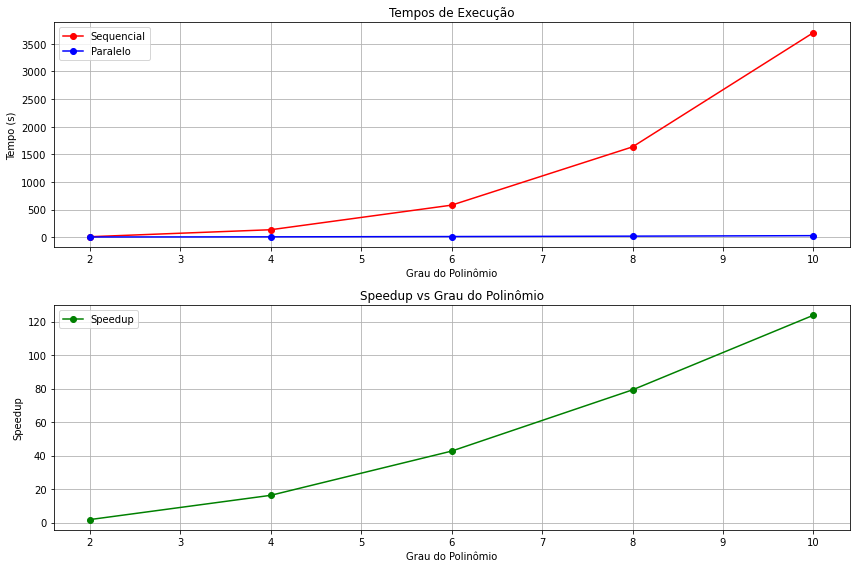


[INFO] Gráfico de comparação salvo como 'comparacao_tempo_speedup.png'.


In [4]:
import os
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Settings
cuda_file = "hack-cuda-lapack.cu"
sequential_file = "r3d-sequential-lapack.c"
parallel_executable = "hack-cuda-lapack"
sequential_executable = "r3d-sequential-lapack"
degrees = [2, 4, 6, 8, 10]  # Degrees of the polynomial to be tested

# Compilation of CUDA files
print("[INFO] Compilando os arquivos CUDA...")
compilation_commands = [
    f"nvcc -o {parallel_executable} {cuda_file} -Xcompiler -fopenmp -lopenblas -lm -O3",
    f"g++ -o {sequential_executable} {sequential_file} -fopenmp -lopenblas -lm -O3"
]

for command in compilation_commands:
    compilation_result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if compilation_result.returncode != 0:
        print("[ERRO] Falha na compilação!")
        print(compilation_result.stderr.decode("utf-8"))
        raise SystemExit

print("[INFO] Compilação bem-sucedida.")

# Execution for different grades and collection of times
sequential_times = []
parallel_times = []
print("\n[INFO] Executando o programa para diferentes graus do polinômio...")

for r in degrees:
    # Run sequential version
    command_sequential = f"./{sequential_executable} {r}"
    print(f"\n[INFO] Executando versão sequencial para grau do polinômio: {r}")
    start_time = time.time()
    result_sequential = subprocess.run(command_sequential, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()

    if result_sequential.returncode != 0:
        print(f"[ERRO] Falha na execução sequencial para grau {r}.")
        print(result_sequential.stderr.decode("utf-8"))
        sequential_times.append(np.nan)
    else:
        elapsed_time = end_time - start_time
        print(f"[INFO] Tempo sequencial para grau {r}: {elapsed_time:.2f} segundos")
        sequential_times.append(elapsed_time)

    # Run parallel version
    command_parallel = f"./{parallel_executable} {r}"
    print(f"[INFO] Executando versão paralela para grau do polinômio: {r}")
    start_time = time.time()
    result_parallel = subprocess.run(command_parallel, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    end_time = time.time()

    if result_parallel.returncode != 0:
        print(f"[ERRO] Falha na execução paralela para grau {r}.")
        print(result_parallel.stderr.decode("utf-8"))
        parallel_times.append(np.nan)
    else:
        elapsed_time = end_time - start_time
        print(f"[INFO] Tempo paralelo para grau {r}: {elapsed_time:.2f} segundos")
        parallel_times.append(elapsed_time)

# Calculate Speedups
print("\n[INFO] Calculando Speedups...")
speedups = [
    seq / par if seq and par else np.nan
    for seq, par in zip(sequential_times, parallel_times)
]

print("\n[RESULTADOS]")
print("Grau do Polinômio | Tempo Sequencial (s) | Tempo Paralelo (s) | Speedup")
for i, r in enumerate(degrees):
    print(f"{r:<18} | {sequential_times[i]:<22.2f} | {parallel_times[i]:<22.2f} | {speedups[i]:.2f}")

# Save results to file
output_file = "resultados_comparacao.txt"
print(f"\n[INFO] Salvando os resultados em {output_file}...")
with open(output_file, "w") as f:
    f.write("Grau do Polinômio | Tempo Sequencial (s) | Tempo Paralelo CUDA (s) | Speedup\n")
    for i, r in enumerate(degrees):
        f.write(f"{r:<18} | {sequential_times[i]:<22.2f} | {parallel_times[i]:<22.2f} | {speedups[i]:.2f}\n")

# Plot graphs
plt.figure(figsize=(12, 8))

# Subplot 1: Execution times
plt.subplot(2, 1, 1)
plt.plot(degrees, sequential_times, marker='o', linestyle='-', color='r', label='Sequencial')
plt.plot(degrees, parallel_times, marker='o', linestyle='-', color='b', label='Paralelo')
plt.title('Tempos de Execução')
plt.xlabel('Grau do Polinômio')
plt.ylabel('Tempo (s)')
plt.grid(True)
plt.legend()

# Subplot 2: Speedup
plt.subplot(2, 1, 2)
plt.plot(degrees, speedups, marker='o', linestyle='-', color='g', label='Speedup')
plt.title('Speedup vs Grau do Polinômio')
plt.xlabel('Grau do Polinômio')
plt.ylabel('Speedup')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('comparacao_tempo_speedup.png')
plt.show()

print("\n[INFO] Gráfico de comparação salvo como 'comparacao_tempo_speedup.png'.")


### I) Validação com Valores Pequenos

#### Parâmetros Ótimos de Execução

1. CUDA = G1D B1DT1D (**32** * 32, 1024)

### Tempos de execução em segundos das aplicações

|  Grau | SequencialLapack  |  CUDA   |
| ------| ----------------- | --------|
|   2   |   10,54s          | 5,74s   | 
|   4   |   136,88s         | 8,39s   |
|   6   |   581,72s         | 13,62s  | 
|   8   |   1635,87s        | 20,63s  |
|  10   |   3832s           | 30s     |                                                                                                   |  20   |   52.083s         | 135,55s |

|  Grau | SequencialLapack  |  CUDA   |
| ------| ----------------- | --------|
|  20   |   52.083s         | 135,55s |

### Speedups

|  Grau      | SpeedUpCUDA  |
| -----------|------------- |
| 2          |     1,8x     |  
| 4          |    16,3x     |           
| 6          |    42,7x     |
| 8          |    79,3x     |         
| 10         |   127,7x     |   
| 20         |   385x       |

### II) Análise de Desempenho com um valor alto - Grau do Polinômio = `20`

#### Parâmetros Ótimos de Execução

1. CUDA = G1D B1DT1D (**32** * 32, 1024)

### Tempo de execução em segundos das aplicações (referência @muriloboratto)

|  Grau        | Sequencial Lapack| OpenMP  |  CUDA (1 GPU)
| -------------| ---------------- | ------- |  -----------
| 10           | 2060.14          | 62.55   |      14.72
| 20           | 27986.75         | 744.77  |      70.03


### Speedup (referência @muriloboratto)

|  Grau        |  OpenMP    |  CUDA (1GPU)
| -------------|  --------  |  -----------
| 10           |  32X       |     139X
| 20           |  37X       |     399X


## Conclusões

Após as análises realizadas e demonstrada via gráficos, é possível inferir que com o uso da paralelização, especialmente usando CUDA, podemos atingir resultados surpreendentes, e proporcionais ao grau de complexidade de resolução do problema, tornando assim essencial para desafios de grande magnitude computacional.

## Referências Biliográficas

* G. Coulouris, J. Dollimore, T. Kindberg, G.Blair. Distributed Systems: Concepts and Design, Fifth Edition, Pearson, 2011.

* S.Tanenbaum, M. Steen, Distributed Systems: Principles and Paradigms, Second Edition, Pearson, 2006.

* David A. Patterson and John L. Hennessy. Computer Organization and Design: The Hardware/Software Interface. Morgan Kaufmann, 5th Edition, 2013.

* An Introduction to Parallel Programming by Peter S. Pacheco. Morgan Kauffman.

* W. C. Barbosa, An introduction to distributed algorithms, MIT Press, 1997. N. Lynch, Distributed Algorithms, Mit Press, 1996 e Introduction to Distributed Algorithms, Gerard Tel, Cabribridge U. Press, 1994.